In [0]:
# General
import numpy as np
import pandas as pd
import os
from zipfile import ZipFile
import time
import altair as alt

# For modeling the Neural Network
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from mpl_toolkits.mplot3d import axes3d
from tensorflow.keras import layers
from tensorflow.keras.layers import Lambda, Input, Dense, Conv2D, Flatten, Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img

# For images 
from PIL import Image
import matplotlib.pyplot as plt
from IPython import display
import PIL
import glob
import imageio

# For clustering and understanding
from sklearn.manifold import TSNE, MDS
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

In [0]:
#!pip install altair==3.0

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
img_width = 80
img_height = 80
channels =  4

pokemon = []
directory = '/content/gdrive/My Drive/2020/P02_Pokemon-generator/data/imgs.zip' 
with open(directory, 'rb') as fp:
  archive = ZipFile(fp)
  for entry in archive.infolist():
    with archive.open(entry) as file:
      try:
        img = Image.open(file)
        img = img.resize((img_width,img_height), Image.ANTIALIAS)
        #img = img.convert('RGB')
        pokemon.append(np.asarray(img))
      except:
        continue
        

In [188]:
pokemon = np.array(pokemon)
print(pokemon.shape)

(888, 80, 80, 4)


In [0]:
def plotImages(images_arr):
    '''Takes an image array of 5 figures and plots it

    Parameters
    -------------------------
    images_arr: np.array
      array of images to plot
    '''
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    images_arr.squeeze()
    for img, ax in zip(images_arr, axes):
        img = img.squeeze()
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

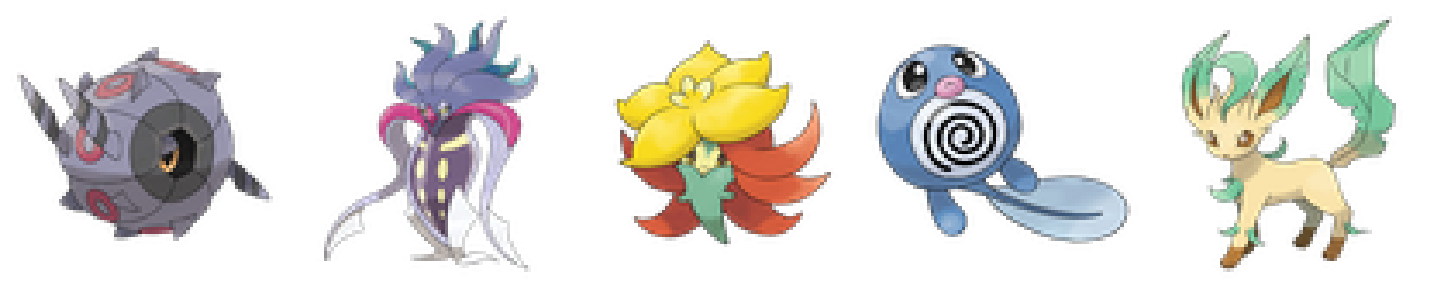

In [190]:
random_index = np.random.choice(pokemon.shape[0], 5)
random_images = pokemon[random_index]
plotImages(random_images)

## Autoencoder

In [205]:
input_shape = (img_width, img_height, channels)
latent_dim = 400
batch_size= 128
epochs = 300

# Encoder
input_img = Input(shape=input_shape)

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Flatten()(x)
x = Dense(latent_dim, activation='relu')(x)
encoder = Model(input_img, x, name='encoder')
encoder.summary()

# Decoder

latent_inputs = Input(shape=(latent_dim,), name='latent_dim')
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
#x = UpSampling2D((2, 2))(x)
outputs = Conv2D(channels, (3, 3), activation='sigmoid', padding='same')(x)

decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# instantiate CAE model
outputs = decoder(encoder(input_img))
cae = Model(input_img, outputs, name='cae')

# Adding the loss
reconstruction_loss = binary_crossentropy(K.flatten(outputs),
                                          K.flatten(input_img))
cae_loss = K.mean(reconstruction_loss)
cae.add_loss(cae_loss)
cae.compile(optimizer='rmsprop')

models = (encoder, decoder)


Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_61 (InputLayer)        (None, 80, 80, 4)         0         
_________________________________________________________________
conv2d_344 (Conv2D)          (None, 80, 80, 16)        592       
_________________________________________________________________
max_pooling2d_164 (MaxPoolin (None, 40, 40, 16)        0         
_________________________________________________________________
conv2d_345 (Conv2D)          (None, 40, 40, 8)         1160      
_________________________________________________________________
max_pooling2d_165 (MaxPoolin (None, 20, 20, 8)         0         
_________________________________________________________________
conv2d_346 (Conv2D)          (None, 20, 20, 8)         584       
_________________________________________________________________
max_pooling2d_166 (MaxPoolin (None, 10, 10, 8)         0   

/usr/local/lib/python3.6/dist-packages/keras/engine/training_utils.py:819: UserWarning: Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.
  'be expecting any data to be passed to {0}.'.format(name))


In [207]:
from keras.callbacks import TensorBoard

early_stop = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)
cae.fit(pokemon,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop])
#                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Epoch 1/300
888/888 [==============================] - 1s 965us/step - loss: 7.0519
Epoch 2/300
888/888 [==============================] - 1s 768us/step - loss: 5.7600
Epoch 3/300
888/888 [==============================] - 1s 772us/step - loss: 3.9367
Epoch 4/300
888/888 [==============================] - 1s 772us/step - loss: 2.8776
Epoch 5/300
888/888 [==============================] - 1s 768us/step - loss: 2.4638
Epoch 6/300
888/888 [==============================] - 1s 769us/step - loss: 2.2215
Epoch 7/300
888/888 [==============================] - 1s 770us/step - loss: 2.0041
Epoch 8/300
888/888 [==============================] - 1s 776us/step - loss: 1.8040
Epoch 9/300
888/888 [==============================] - 1s 771us/step - loss: 1.7790
Epoch 10/300
888/888 [==============================] - 1s 771us/step - loss: 1.5688
Epoch 11/300
888/888 [==============================] - 1s 773us/step - loss: 1.5954
Epoch 12/300
888/888 [==============================] - 1s 770us/step - lo

In [0]:
# Saving path
saving_path = '/content/gdrive/My Drive/2020/P02_Pokemon-generator/vae_pokemon'
cae.save_weights(saving_path)

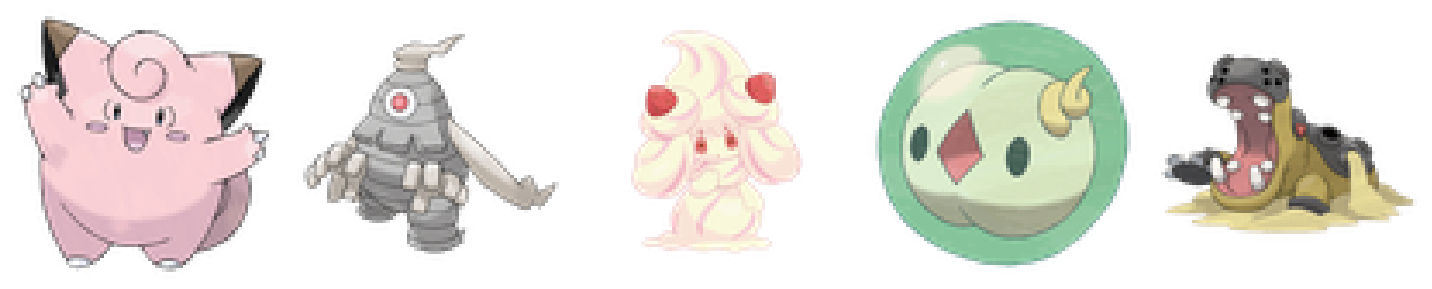

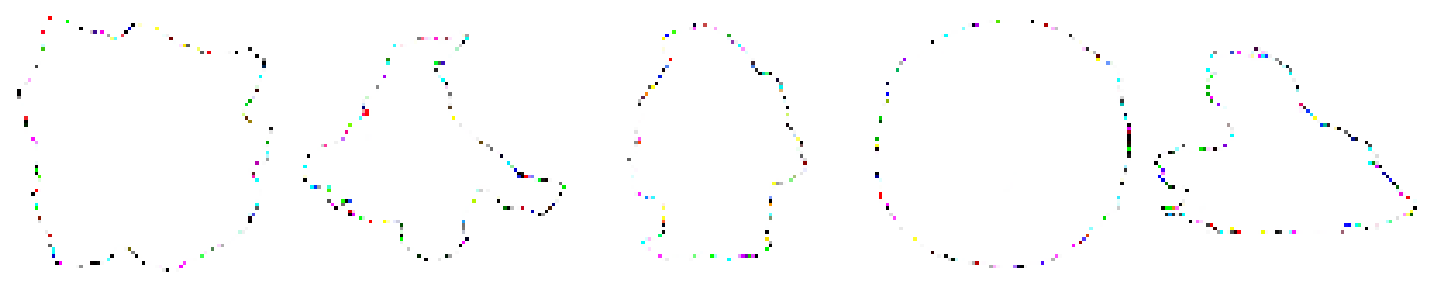

In [208]:
random_indexes = np.random.choice(pokemon.shape[0], 5)
random_images = pokemon[random_indexes]
reconstructed = cae.predict(random_images)

plotImages(random_images)
plotImages(reconstructed)

## Using the latent dimension

In [0]:
def concatenate_and_plot(data, labels):
  ''' 
  Creates a visualization for a cluster method

  Parameters
  ------------------------------
  data: (np.array)
    2D array of data
  labels: (np.array)
    1D array of results labels
  
  Returns
  ------------------------------
  plot: (altair plot)
    clustering plot
  '''
  concatenated_data = np.hstack((data, labels.reshape((-1,1))))
  data_df = pd.DataFrame(concatenated_data, columns = ['X1','X2', 'label'])

  plot = alt.Chart(data_df).mark_circle(opacity = 0.3).encode(
              alt.X('X2:Q'),
              alt.Y('X1:Q'),
              alt.Color('label:N')
          )
  
  return plot

In [0]:
def img_tiling(idx, array, dims, size = 1000):
    """
    Plots a 5x5 tiling of faces.
    
    Parameters:
    -----------
    idx: the indexes of the faces to be plotted. This should be a 5x5 matrix, where each 
         elements is an index corresponding to the closest face of that grid point.
     
    size: the desired size of the plot;
    """
    
    # Just making sure the indexes are int
    idx = np.array(idx, dtype="int32")
    
    #Creating the image with the desired size
    plt.figure(figsize=(size, size))
    
    #Ploting the 5x5 tiling
    for i,x in enumerate(np.linspace(np.min(latent_points[:,0]),np.max(latent_points[:,0]),dims)):
        for j,y in enumerate(np.linspace(np.min(latent_points[:,1]),np.max(latent_points[:,1]), dims)):
            item = np.reshape(array[idx[i,j],:,:,:], (img_width, img_height,-1)) # Obtain the closest face
            plt.imshow(item, extent=(i*img_width,(i+1)*img_width,j*img_width,(j+1)*img_width)) # Plot the closest face
   
    plt.xlim((0,img_width*dims))
    plt.ylim((0,img_height*dims))
    plt.xticks([])
    plt.yticks([])

In [209]:
latent_points = encoder.predict(pokemon, 
                                batch_size=batch_size,
                                     verbose=1)

888/888 [==============================] - 0s 161us/step


In [210]:
latent_points.shape

(888, 400)

In [0]:
images_TSNE = TSNE(random_state=1)
projected_points = images_TSNE.fit_transform(latent_points)

In [212]:
tsne_df = pd.DataFrame(projected_points, columns=['X1', 'X2'])
all_points = alt.Chart(tsne_df).mark_point(color = 'black').encode(
              alt.X('X2:Q'),
              alt.Y('X1:Q')
          )

all_points

Chart({
  data:             X1         X2
  0     0.524616  25.624111
  1    20.539183   3.107826
  2    17.598717 -28.737486
  3     6.529638  33.263260
  4     7.253442  -4.053331
  ..         ...        ...
  883  -1.266225   3.443526
  884  -4.249539  11.119880
  885 -28.072369  10.470841
  886  -6.843257  -2.026881
  887  -3.664841  -6.911249
  
  [888 rows x 2 columns],
  encoding: FacetedEncoding({
    x: X({
      shorthand: 'X2:Q'
    }),
    y: Y({
      shorthand: 'X1:Q'
    })
  }),
  mark: MarkDef({
    color: 'black',
    type: 'point'
  })
})

In [218]:
max_values = np.max(projected_points, axis = 0)
min_values = np.min(projected_points, axis = 0)

n_steps = 7
x1_sequence = np.linspace(min_values[0], max_values[0], n_steps)
x2_sequence = np.linspace(min_values[1], max_values[1], n_steps)

comb_array = np.stack(np.meshgrid(x1_sequence, x2_sequence), -1)
combinations = comb_array.reshape((-1, 1, 2))  
comb_points = pd.DataFrame(combinations.reshape((-1, 2)), columns = ['X1', 'X2'])

distance_point = np.sqrt(np.sum(((projected_points - combinations)**2), axis = 2))
closest_points = np.argmin(distance_point, axis = 1)

closets_df = pd.DataFrame(projected_points[closest_points,:], columns = ['X1', 'X2'])

chosen_points = alt.Chart(comb_points).mark_circle(color = '#c73d32').encode(
                alt.X('X2:Q'),
                alt.Y('X1:Q')
            )
closests = alt.Chart(closets_df).mark_circle(color = '#89cff0').encode(
                alt.X('X2:Q'),
                alt.Y('X1:Q')
            )

all_points + chosen_points + closests

LayerChart({
  layer: [Chart({
    data:             X1         X2
    0     0.524616  25.624111
    1    20.539183   3.107826
    2    17.598717 -28.737486
    3     6.529638  33.263260
    4     7.253442  -4.053331
    ..         ...        ...
    883  -1.266225   3.443526
    884  -4.249539  11.119880
    885 -28.072369  10.470841
    886  -6.843257  -2.026881
    887  -3.664841  -6.911249
    
    [888 rows x 2 columns],
    encoding: FacetedEncoding({
      x: X({
        shorthand: 'X2:Q'
      }),
      y: Y({
        shorthand: 'X1:Q'
      })
    }),
    mark: MarkDef({
      color: 'black',
      type: 'point'
    })
  }), Chart({
    data:            X1         X2
    0  -33.878387 -33.796894
    1  -23.104508 -33.796894
    2  -12.330629 -33.796894
    3   -1.556749 -33.796894
    4    9.217130 -33.796894
    5   19.991009 -33.796894
    6   30.764889 -33.796894
    7  -33.878387 -22.546606
    8  -23.104508 -22.546606
    9  -12.330629 -22.546606
    10  -1.556749 -22.546606
    11   9.217130 -22.546606
    12  19.991009 -22.546606
    13  30.764889 -22.546606
    14 -33.878387 -11.296318
    15 -23.104508 -11.296318
    16 -12.330629 -11.296318
    17  -1.556749 -11.296318
    18   9.217130 -11.296318
    19  19.991009 -11.296318
    20  30.764889 -11.296318
    21 -33.878387  -0.046030
    22 -23.104508  -0.046030
    23 -12.330629  -0.046030
    24  -1.556749  -0.046030
    25   9.217130  -0.046030
    26  19.991009  -0.046030
    27  30.764889  -0.046030
    28 -33.878387  11.204258
    29 -23.104508  11.204258
    30 -12.330629  11.204258
    31  -1.556749  11.204258
    32   9.217130  11.204258
    33  19.991009  11.204258
    34  30.764889  11.204258
    35 -33.878387  22.454546
    36 -23.104508  22.454546
    37 -12.330629  22.454546
    38  -1.556749  22.454546
    39   9.217130  22.454546
    40  19.991009  22.454546
    41  30.764889  22.454546
    42 -33.878387  33.704834
    43 -23.104508  33.704834
    44 -12.330629  33.704834
    45  -1.556749  33.704834
    46   9.217130  33.704834
    47  19.991009  33.704834
    48  30.764889  33.704834,
    encoding: FacetedEncoding({
      x: X({
        shorthand: 'X2:Q'
      }),
      y: Y({
        shorthand: 'X1:Q'
      })
    }),
    mark: MarkDef({
      color: '#c73d32',
      type: 'circle'
    })
  }), Chart({
    data:            X1         X2
    0  -24.836418 -21.652607
    1  -18.559412 -26.192205
    2   -9.348745 -27.957855
    3    0.024783 -29.654318
    4   10.850443 -33.796894
    5   17.598717 -28.737486
    6   17.598717 -28.737486
    7  -25.280914 -20.215805
    8  -24.836418 -21.652607
    9  -11.587152 -24.528463
    10  -2.537991 -22.443022
    11   9.378805 -22.499285
    12  18.777231 -24.386003
    13  22.603842 -21.067400
    14 -33.878387  -8.952417
    15 -24.882420 -10.787646
    16 -12.188930 -10.416472
    17  -1.911446 -12.016838
    18   9.294813 -11.343373
    19  21.446026  -9.845137
    20  27.164831  -8.691351
    21 -31.147482  -0.815853
    22 -22.329985   0.514811
    23 -12.308334   0.167680
    24  -2.053268   0.557360
    25  10.033442  -0.511743
    26  19.946018  -0.643362
    27  30.309147   4.066175
    28 -32.559170   8.773191
    29 -24.018990  11.262618
    30 -12.349097  10.250406
    31  -1.099212  10.413850
    32   9.212461  11.897553
    33  20.323223  11.715743
    34  29.176363   9.801041
    35 -22.606174  20.199274
    36 -22.606174  20.199274
    37 -13.811598  23.427212
    38  -0.362416  21.794298
    39   9.253041  23.056671
    40  21.188797  22.176500
    41  27.791147  22.074131
    42 -22.606174  20.199274
    43 -14.148283  26.028975
    44  -9.465903  30.242064
    45  -2.149609  30.831783
    46   9.970704  33.360680
    47  15.529151  30.183697
    48  21.548235  26.295471,
    encoding: FacetedEncoding({
      x: X({
        shorthand: 'X2:Q'
      }),
      y: Y({
        shorthand: 'X1:Q'
      })
    }),
    mark: MarkDef({
      color: '#89cff0',
      type: 'circle'
    })
  })

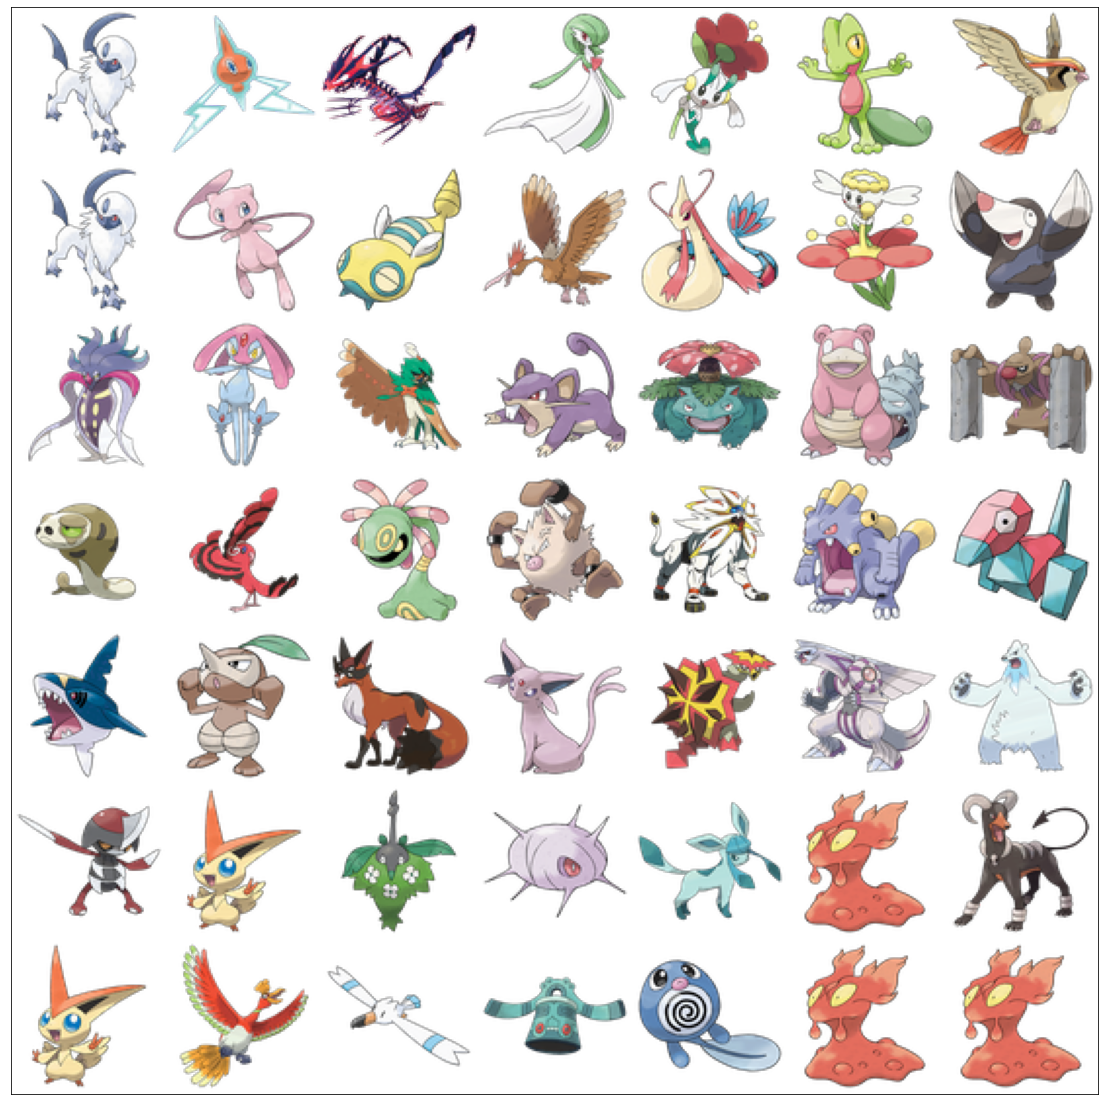

In [219]:
img_tiling(closest_points.reshape(n_steps,n_steps),
           pokemon, n_steps, size = 20)

## GAN

In [0]:
def make_generator_model(IMG_SIZE):
    
    if IMG_SIZE % 4 != 0:
      print("Error! Please use an IMG_SIZE divisible by 4.")
      return

    model = tf.keras.Sequential()
    model.add(layers.Dense(IMG_SIZE // 4 * IMG_SIZE // 4 * 256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((IMG_SIZE // 4, IMG_SIZE // 4, 256)))
    assert model.output_shape == (None, IMG_SIZE // 4, IMG_SIZE // 4, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, IMG_SIZE // 4, IMG_SIZE // 4, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, IMG_SIZE // 2, IMG_SIZE // 2, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(4, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, IMG_SIZE, IMG_SIZE, 4)

    return model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


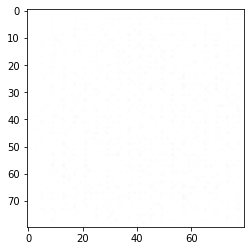

In [297]:
generator = make_generator_model(img_width)

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :]);

In [0]:
def make_discriminator_model(IMG_SIZE):
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[IMG_SIZE, IMG_SIZE, 4]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [299]:
discriminator = make_discriminator_model(img_width)
decision = discriminator(generated_image)
print(f"Output = {np.squeeze(decision.numpy()):.5f}")
print(" Class = Real") if np.squeeze(decision.numpy()) > 0 else print(" Class = Fake")

Output = 0.00049
 Class = Real


In [0]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return tf.reduce_mean(0.5*total_loss)

In [0]:
def generator_loss(fake_output):
    return tf.reduce_mean(cross_entropy(tf.ones_like(fake_output), fake_output))

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [0]:
noise_dim = 100
num_examples_to_generate = 4

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [0]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss

In [0]:
def train(dataset, data_size, epochs=5):
  losses_on_epoch = {'g_losses' :[], 'd_losses': [], 'epochs': []}


  for epoch in range(epochs):
    print(f"Starting epoch {epoch+1}.")
    start = time.time()

    g_losses = []
    d_losses = []

    batch = 0
    #for image_batch, _ in dataset: # this is for image generator 
    for image_batch in dataset: # this is for array
      if batch % 50 == 0:
        print(f"  Starting batch {batch+1}/{len(dataset)}")
      g_loss, d_loss = train_step(image_batch)
      g_losses.append(g_loss.numpy())
      d_losses.append(d_loss.numpy())
      batch += 1
      if batch >= len(dataset):
        break
    print("  Done train step.")
    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)
    
    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    # plot loss on each epoch
    g_loss_mean, d_loss_mean = summarize_epoch(epoch, d_losses, g_losses, data_size, epochs)
    # save the losses
    losses_on_epoch['g_losses'].append(g_loss_mean)
    losses_on_epoch['d_losses'].append(d_loss_mean)
    losses_on_epoch['epochs'].append(epoch + 1)
    
    
    print ('  Time taken for epoch {} is {} sec.'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)
  # plot loss after all epoches
  plot_loss_over_epoch(losses_on_epoch['g_losses'],losses_on_epoch['d_losses'],losses_on_epoch['epochs'])
  print('g_loss: {} \nd_loss: {}'.format(losses_on_epoch['g_losses'][-1],losses_on_epoch['d_losses'][-1]))

In [0]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(1,4), dpi=600)
  for i in range(predictions.shape[0]):
      plt.subplot(1, 4, i+1)
      p = predictions[i, :, :]
      p = (p - np.min(p))/np.ptp(p)
      plt.imshow(p)
      plt.axis('off')

  plt.savefig(f'/content/gdrive/My Drive/2020/P02_Pokemon-generator/image_{epoch:04d}.png')
  plt.show()

In [0]:
def get_batches(data):
    batches = []
    for i in range(int(data.shape[0]//BATCH_SIZE)):
        batch = data[i * BATCH_SIZE:(i + 1) * BATCH_SIZE]
        augmented_images = []
        for img in batch:
            image = array_to_img(img)
            if np.random.choice([True, False]):
                image = image.transpose(Image.FLIP_LEFT_RIGHT)
            augmented_images.append(np.asarray(image))
        batch = np.asarray(augmented_images)
        normalized_batch = (batch / 127.5) - 1.0
        batches.append(normalized_batch)
    return batches

In [0]:
def summarize_epoch(epoch, g_losses, d_losses, data_size, EPOCHS = 5):
    minibatch_size = int(data_size//BATCH_SIZE)
    g_loss_mean = np.mean(g_losses[-minibatch_size:])
    d_loss_mean = np.mean(d_losses[-minibatch_size:])
    print("Epoch {}/{}".format(epoch + 1, EPOCHS),
          "\nG Loss: {:.5f}".format(g_loss_mean),
          "\nD Loss: {:.5f}".format(d_loss_mean))
    #fig, ax = plt.subplots()
    #plt.plot(g_losses, label='Generator', alpha=0.6)
    #plt.plot(d_losses, label='Discriminator', alpha=0.6)
    #plt.title("Losses")
    #plt.legend()
    # save losses each 15 epoches
    #if (epoch + 1) % 15 == 0:
    #  plt.savefig(f'/content/gdrive/My Drive/2020/591_Capstone_Image-generation/losses_{epoch:04d}.png')
    #plt.show()
    #plt.close()
    return g_loss_mean,d_loss_mean

In [0]:
def plot_loss_over_epoch(g_losses,d_losses,epochs):
  fig, ax = plt.subplots()
  plt.plot(g_losses, label='Generator', alpha=0.6)
  plt.plot(d_losses, label='Discriminator', alpha=0.6)
  plt.title("Losses")
  plt.xticks(epochs)
  plt.legend()
  plt.savefig(f'/content/gdrive/My Drive/2020/P02_Pokemon-generator/losses_{epochs:04d}.png')
  plt.show()
  plt.close()

In [0]:
EPOCHS = 700
BATCH_SIZE = batch_size
train(get_batches(pokemon),pokemon.shape[0], EPOCHS)

In [0]:
def display_image(epoch_no):
  return PIL.Image.open(f'/content/gdrive/My Drive/2020/P02_Pokemon-generator/image_{epoch_no:04d}.png')

In [0]:
display_image(EPOCHS)

In [0]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('/content/gdrive/My Drive/2020/P02_Pokemon-generator/image_*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

In [0]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(anim_file)